<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/synthetic_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

model='M2'

Cloning into 'thesis'...
remote: Enumerating objects: 1319, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1319 (delta 24), reused 19 (delta 10), pack-reused 1273
Receiving objects: 100% (1319/1319), 61.81 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (845/845), done.
Updating files: 100% (64/64), done.
Mounted at /content/drive


## Prepare Data

In [2]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')

In [5]:
fb = fb[fb['temporal_distance_birth_h'] < 100].copy()
fb['temporal_distance_birth_base_100h'] = fb['temporal_distance_birth_h'] / 100
fb['IAT_base_100h']=fb['IAT_user_thread']/(60*60*100)

gb = gb[gb['temporal_distance_birth_h'] < 100].copy()
gb['temporal_distance_birth_base_100h'] = gb['temporal_distance_birth_h'] / 100
gb['IAT_base_100h']=gb['IAT_user_thread']/(60*60*100)

rd = rd[rd['temporal_distance_birth_h'] < 100].copy()
rd['IAT_base_100h']=rd['IAT_user_thread']/(60*60*100)
rd['temporal_distance_birth_base_100h'] = rd['temporal_distance_birth_h'] / 100

vo = vo[vo['temporal_distance_birth_h'] < 100].copy()
vo['IAT_base_100h']=vo['IAT_user_thread']/(60*60*100)
vo['temporal_distance_birth_base_100h'] = vo['temporal_distance_birth_h'] / 100


## Search parameters

In [6]:
from SYN_package.estimate_parameters import *
params_dict={}

names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]  # Assuming vo, fb, rd, yt are your actual dataframes

params_dict = process_social_platform(names, datas)
print(params_dict)

  0%|          | 0/4 [03:56<?, ?it/s]


KeyboardInterrupt: 

In [7]:
params_dict={'gb': {'gamma': 3.215282467909702,
  'a': 0.4018256269460139,
  'b': 104.43829857709679,
  'loc': 0.0009999999999999998,
  'scale': 13.01795195375287,
  'alpha': 0.2,
  'lambda': 0.15000000000000002,
  'c': 1.1526181678983425,
  'd': 0.12186062608219086,
  'l': 2.7777777777777775e-06,
  's': 1.2435475829755767,
  'cf': 0.8447527697340091,
  'df': 0.19163933251151466,
  'lf': 2.7777777777777775e-06,
  'sf': 1.5688864219589722,
  'ka': 0.8896559938093019,
  'kb': 1.4418533144013064,
  'kloc': 0.0025094102885821826,
  'kscale': 1.0028863442067695},
 'rd': {'gamma': 2.1172386372477376,
  'a': 1.3208418726992361,
  'b': 366274394.2558266,
  'loc': 0.00043188573340450587,
  'scale': 21377429.04281839,
  'alpha': 0.3,
  'lambda': 0.5500000000000002,
  'c': 1.4035122312087873,
  'd': 0.34547543092801714,
  'l': 2.777777777776469e-06,
  's': 0.009685929534020282,
  'cf': 1.061267002974987,
  'df': 0.16381176822206486,
  'lf': 2.7777777777777775e-06,
  'sf': 1.708837260306469,
  'ka': 1.0049866066618744,
  'kb': 0.996610258519959,
  'kloc': 0.00555546412073109,
  'kscale': 0.9883095665541157},
 'fb': {'gamma': 1.920612852062878,
  'a': 0.3844295492882861,
  'b': 294.47288219865607,
  'loc': 0.0009999999999999998,
  'scale': 33.07578198818712,
  'alpha': 0.1,
  'lambda': 1.2000000000000004,
  'c': 1.4925263821442911,
  'd': 0.08849381153322906,
  'l': 2.7777777777777775e-06,
  's': 1.3440750553651393,
  'cf': 1.1530515610823424,
  'df': 0.1221286925154284,
  'lf': 2.7777777777777775e-06,
  'sf': 1.243471290490271,
  'ka': 1.3719107617595574,
  'kb': 1.5592114694474652,
  'kloc': 0.0004140220290478528,
  'kscale': 1.0021511676384194},
 'vo': {'gamma': 5.560174158235733,
  'a': 0.7683453768943135,
  'b': 181.35859916908146,
  'loc': 0.0009999999999999998,
  'scale': 10.849357267138616,
  'alpha': 0.35,
  'lambda': 0.45000000000000007,
  'c': 1.3825444184574849,
  'd': 0.3148667223304995,
  'l': -7.559994673910446e-07,
  's': 0.014817594985246601,
  'cf': 5.288800316735881,
  'df': 0.04913571005774435,
  'lf': 2.7777777777777775e-06,
  'sf': 0.24403022567064098,
  'ka': 1.421501788319785,
  'kb': 1.4437470395950163,
  'kloc': 0.004642809547856136,
  'kscale': 1.0151779746283898}}

### Functions

In [78]:
import math
from scipy.stats import beta, burr

def positioning_replies(data, c, d, l, s, Ns, a, b, loc, scale):
    first_comments = sorted([x for sublist in data for x in sublist])
    print(first_comments)
    was_nan = []

    while True:
        candidates = []
        has_nan = False

        # Find all lists with nan and the last non-nan value
        for sublist in data:
            if math.isnan(sublist[-1]):
                non_nan_values = [x for x in sublist if not math.isnan(x)]
                if non_nan_values:
                    candidates.append((non_nan_values[-1], sublist))
                    has_nan = True

        # If there are no more candidates with nan, exit the loop
        if not has_nan:
            break

        candidates.sort(key=lambda x: x[0])
        most_recent_non_nan = candidates[0][0]
        target_list = candidates[0][1]
        all_values = sorted([x for sublist in data for x in sublist if not math.isnan(x)])
        index = all_values.index(most_recent_non_nan)

        k = beta.rvs(a, b, loc, scale, 1)[0]
        K = (k * sum(Ns)).astype(int)

        # Adjust K if it encounters a value that was originally NA
        adjusted_index = index
        for _ in range(K):
            adjusted_index += 1
            if adjusted_index < len(all_values) and all_values[adjusted_index] in was_nan:
                adjusted_index += 1

        if adjusted_index < len(all_values):
            new_value = all_values[adjusted_index]
        else:
            new_value = all_values[-1]

        for i in range(len(target_list)):
            if math.isnan(target_list[i]):
                iat = burr.rvs(c, d, l, s, size=1)
                if (new_value - sum(target_list[:i])) < 0.5*iat:
                    target_list[i] = iat[0]
                elif (new_value - sum(target_list[:i])) > 10 * iat:
                    target_list[i] = iat[0]
                else:
                    target_list[i] = new_value
                was_nan.append(target_list[i])
                break

    return data




def simulate_number_of_comments(alpha, lambda_, size=1):
    # Simulate the inflated component (produces 0 with probability alpha)
    inflate = np.random.binomial(1, alpha, size)
    # Simulate the count component (negative exponential distribution)
    counts = np.random.exponential(1 / lambda_, size)
    # Discretize the exponential values to obtain integer count values
    counts = np.round(counts).astype(int)
    counts[counts < 0] = 0
    # Combine the inflated and count components
    simulated_data = inflate * counts
    return simulated_data


## Simulate synthetic data

In [71]:
number_of_users = 100
T0s = simulate_initial_comment(parameters['a'], parameters['b'], parameters['l'], parameters['s'], size=number_of_users)
Ns = simulate_number_of_comments(parameters['alpha'], parameters['lambda'], number_of_users) + 1
thread = [[T0s[i]] + [np.nan] * (Ns[i] - 1) for i in range(number_of_users)]
filled=positioning_replies(thread, parameters['c'],parameters['d'], parameters['l'], parameters['s'],Ns, parameters['ka'],parameters['kb'], parameters['kloc'], parameters['kscale'])

[5.479981261134693e-06, 1.345146534946363e-05, 1.467666979083826e-05, 1.6063285351758056e-05, 0.00011481648584476764, 0.00031218263985771, 0.0003125307692991172, 0.000337358718494751, 0.0005832671957500421, 0.0006617819595999438, 0.001209694853010062, 0.0012238888182935753, 0.0017470374502128667, 0.0023935391962156835, 0.0025345612032718684, 0.0028340607013399564, 0.003126255407108832, 0.003679480101759308, 0.006392241686747018, nan, 0.003877991800848136, 0.005973367798921826, 0.006776857858978953, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.007142207855204312, nan, 0.0013428253952797444, nan, nan, nan, 0.0015930612014926084, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.006155760327436092, 0.006798446548846434, 0.00844597175001972, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0006830581322931558, 0.0027693644044543913, 0.008202104712925129, nan, nan, 

In [79]:
model='M2'
if model=='M2':
  names = ['vo', 'fb', 'rd', 'gb']
  datas = [vo, fb, rd, gb]  # Assuming vo, fb, rd, yt are your actual dataframes
  time_intervals = np.arange(0, 1, 0.01)
  all_dfs=[]
  for i,df in  (enumerate(datas)):#,total=len(datas)):
      social=names[i]
      parameters=params_dict[social]
      # Simulazione dei dati per la piattaforma corrente
      n = 100
      simulated_t, observed_t = simulate_data_M2(df, parameters['gamma'], parameters['a'], parameters['b'], parameters['loc'],
                                              parameters['scale'], parameters['alpha'], parameters['lambda'], parameters['c'],
                                              parameters['d'], parameters['l'], parameters['s'], parameters['cf'],
                                              parameters['df'], parameters['lf'], parameters['sf'],parameters['ka'],parameters['kb'],parameters['kloc'],parameters['kscale'], num_threads=n,activate_tqdm=False)
      globals()[social+'s'] = simulated_t
      globals()[social+'o'] = observed_t


      # Calcolo dell'ECDF per i dati simulati e osservati
      simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
      simulated_t_ECDF['Platform'] = social
      simulated_t_ECDF['Style'] = 'Simulated'

      observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
      observed_t_ECDF['Platform'] = social
      observed_t_ECDF['Style'] = 'Observed'

      # Concatenazione dei dataframe per simulati e osservati per la piattaforma corrente
      df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
      all_dfs.append(df_platform)

  # Concatenazione di tutti i dataframe delle piattaforme
  df_all = pd.concat(all_dfs, ignore_index=True)
else:
  names = ['vo', 'fb', 'rd', 'gb']
  datas = [vo, fb, rd, gb]  # Assuming vo, fb, rd, yt are your actual dataframes
  time_intervals = np.arange(0, 1, 0.01)
  all_dfs=[]
  for i,df in  (enumerate(datas)):#,total=len(datas))
      social=names[i]
      parameters=params_dict[social]
      # Simulazione dei dati per la piattaforma corrente
      n = 100
      simulated_t, observed_t = simulate_data(df, parameters['gamma'], parameters['a'], parameters['b'], parameters['loc'],
                                              parameters['scale'], parameters['alpha'], parameters['lambda'], parameters['c'],
                                              parameters['d'], parameters['l'], parameters['s'], parameters['cf'],
                                              parameters['df'], parameters['lf'], parameters['sf'],activate_tqdm=True,num_threads=n)

      # Calcolo dell'ECDF per i dati simulati e osservati
      simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
      simulated_t_ECDF['Platform'] = social
      simulated_t_ECDF['Style'] = 'Simulated'

      observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
      observed_t_ECDF['Platform'] = social
      observed_t_ECDF['Style'] = 'Observed'

      # Concatenazione dei dataframe per simulati e osservati per la piattaforma corrente
      df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
      all_dfs.append(df_platform)

  # Concatenazione di tutti i dataframe delle piattaforme
  df_all = pd.concat(all_dfs, ignore_index=True)



Processing DataFrame: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


## Dynamic

### Interaction Model

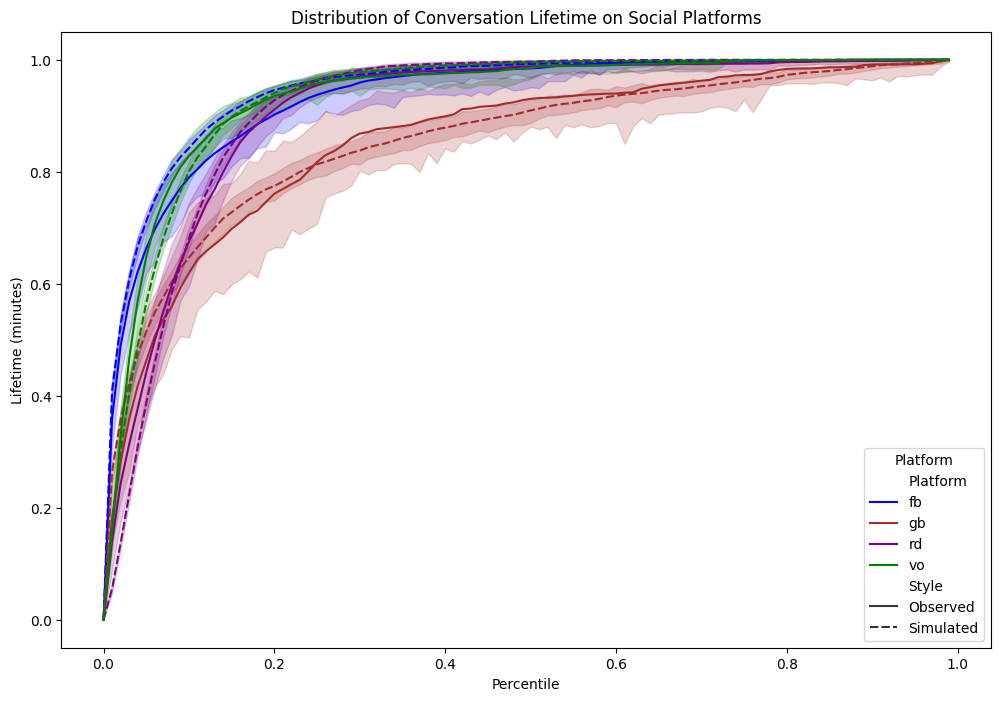

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all is already defined and contains the necessary data
# Custom palette
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all.sort_values(by='Style')

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()





#### Loss

In [80]:
# Loss M2
df_line1 = df_all[df_all['Style'] == 'Simulated']
df_line2 = df_all[df_all['Style'] == 'Observed']

# Assicurarsi che i due dataframe abbiano lo stesso indice per poter fare il confronto
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])

# Unire i due dataframe sulle colonne 'Time Grid Value' e 'Platform'
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')

# Calcolare l'errore quadratico medio (MSE) per ogni piattaforma
mse_per_platform = df_merged.groupby('Platform').apply(
    lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2)
)

print(mse_per_platform)

Platform
fb    0.004521
gb    0.033750
rd    0.007757
vo    0.010592
dtype: float64


### Simple Model

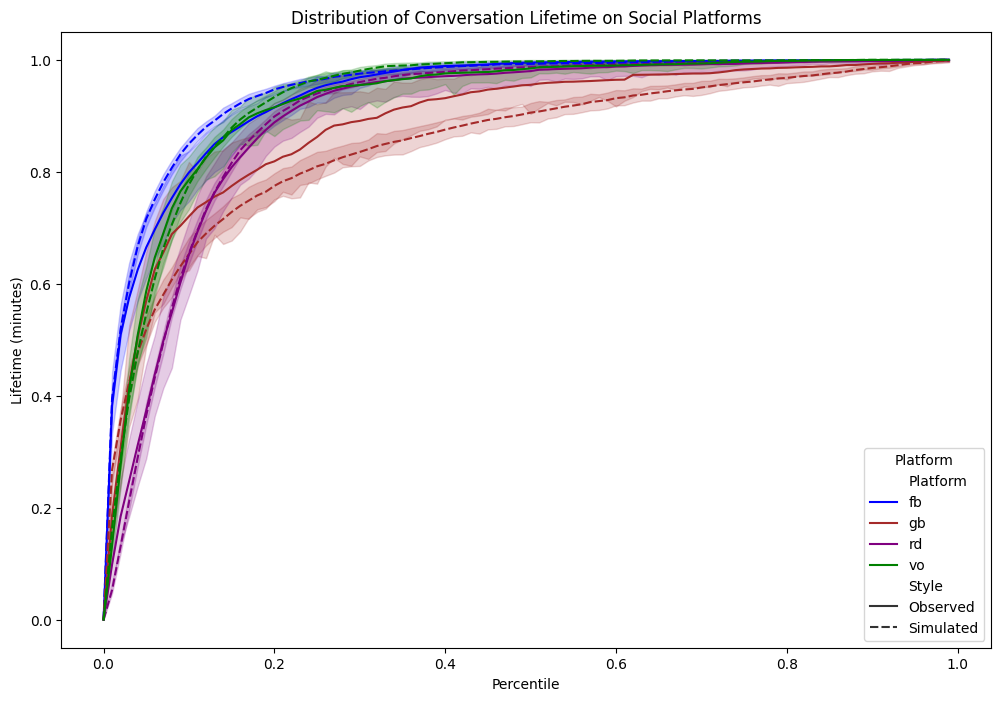

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all is already defined and contains the necessary data
# Custom palette
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all.sort_values(by='Style')

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 100), palette=palette)
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()





#### Loss

In [26]:
# Loss M1
df_line1 = df_all[df_all['Style'] == 'Simulated']
df_line2 = df_all[df_all['Style'] == 'Observed']

# Assicurarsi che i due dataframe abbiano lo stesso indice per poter fare il confronto
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])

# Unire i due dataframe sulle colonne 'Time Grid Value' e 'Platform'
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')

# Calcolare l'errore quadratico medio (MSE) per ogni piattaforma
mse_per_platform = df_merged.groupby('Platform').apply(
    lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2)
)

print(mse_per_platform)

Platform
fb    0.005369
gb    0.027302
rd    0.010767
vo    0.007373
dtype: float64


## Lifetime

<ipython-input-40-799097b0c6ca>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])


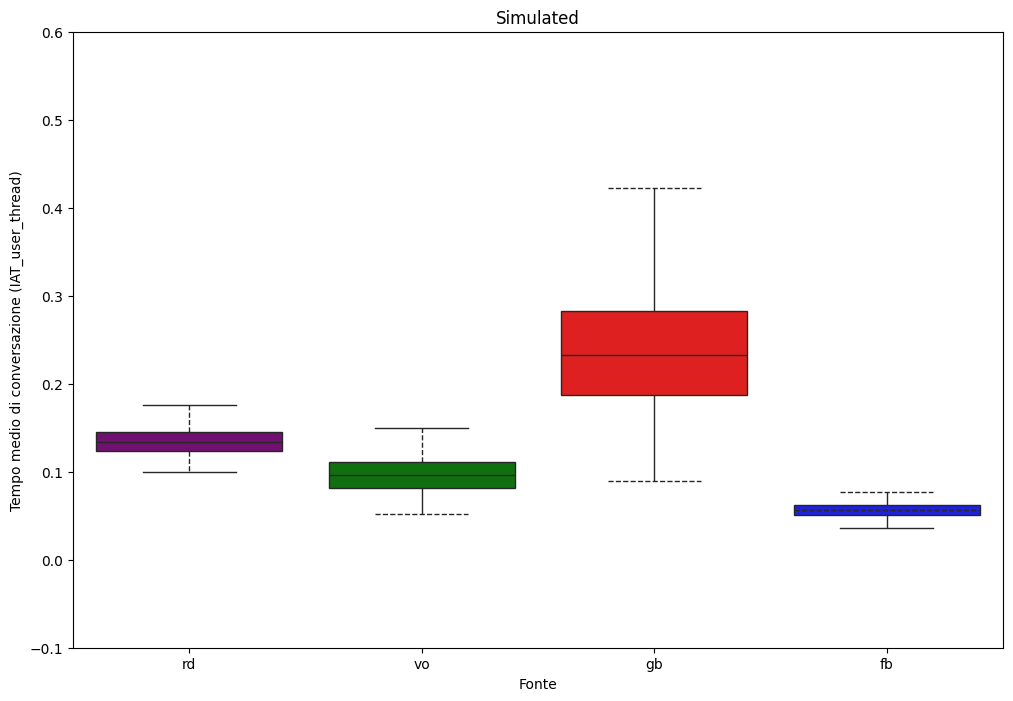

<ipython-input-40-799097b0c6ca>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green','red', 'blue'])


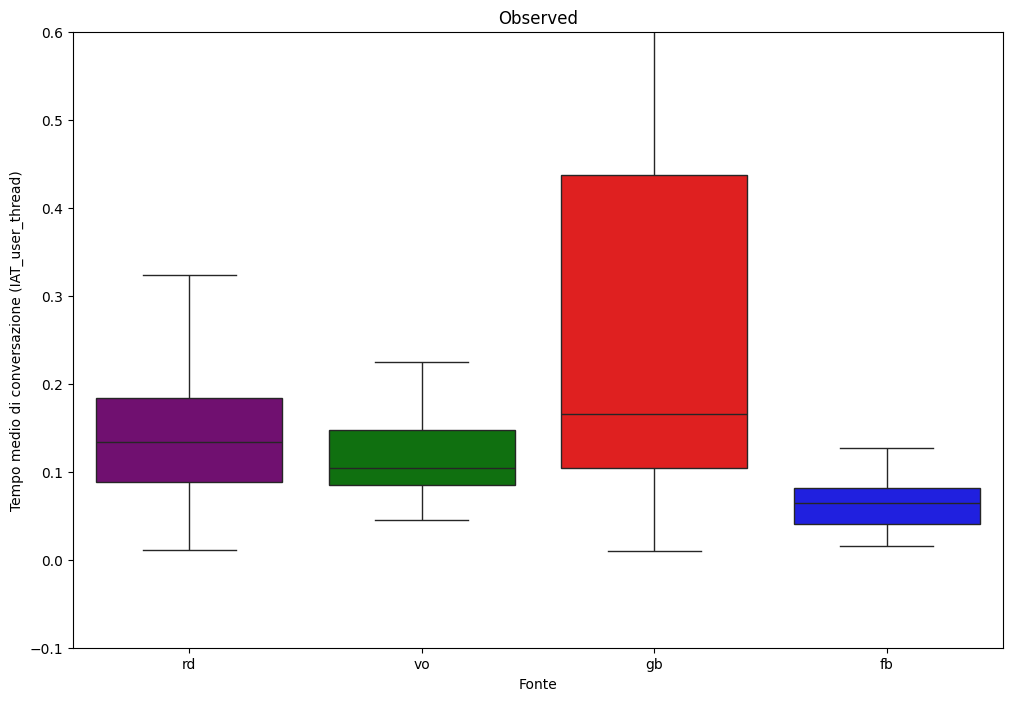

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rds=rds.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbs=fbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
vos=vos.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbs=gbs.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rds.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = vos.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbs.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green', 'red', 'blue'])

# Aggiungere le linee tratteggiate
for i in range(len(combined_data['source'].unique())):
    plt.gca().lines[6*i].set_linestyle('--')
    plt.gca().lines[6*i+1].set_linestyle('--')

plt.title('Simulated')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1, 0.6)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rdo=rdo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
fbo=fbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
voo=voo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
gbo=gbo.groupby(['post_id','user_id'])['temporal_distance_birth_base_100h'].sum().reset_index()


# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_rd = rdo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_rd = time_of_conversation_rd.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in fb
time_of_conversation_fb = fbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in fb
mean_time_of_conversation_fb = time_of_conversation_fb.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in vo
time_of_conversation_vo = voo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in vo
mean_time_of_conversation_vo = time_of_conversation_vo.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()

# Calcolare il tempo totale di conversazione per ogni utente e post in rd
time_of_conversation_yt = gbo.groupby(['user_id', 'post_id'])['temporal_distance_birth_base_100h'].sum().reset_index()
# Calcolare la media del tempo di conversazione per ogni post in rd
mean_time_of_conversation_yt = time_of_conversation_yt.groupby('post_id')['temporal_distance_birth_base_100h'].mean().reset_index()


# Unire i dati per fare il confronto
mean_time_of_conversation_rd['source'] = 'rd'
mean_time_of_conversation_fb['source'] = 'fb'
mean_time_of_conversation_vo['source'] = 'vo'
mean_time_of_conversation_yt['source'] = 'gb'

combined_data = pd.concat([
    mean_time_of_conversation_rd,
        mean_time_of_conversation_vo,
        mean_time_of_conversation_yt,
    mean_time_of_conversation_fb

])

# Creare i boxplot per confrontare le distribuzioni
plt.figure(figsize=(12, 8))
sns.boxplot(x='source', y='temporal_distance_birth_base_100h', data=combined_data, showfliers=False, palette=['purple', 'green','red', 'blue'])
plt.title('Observed')
plt.xlabel('Fonte')
plt.ylabel('Tempo medio di conversazione (IAT_user_thread)')
plt.ylim(-0.1,0.6)
plt.show()


## Conversation

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-81-42e85f76d42d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
<ipython-input-81-42e85f76d42d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')
<ipython-input-81-42e85f76d42d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

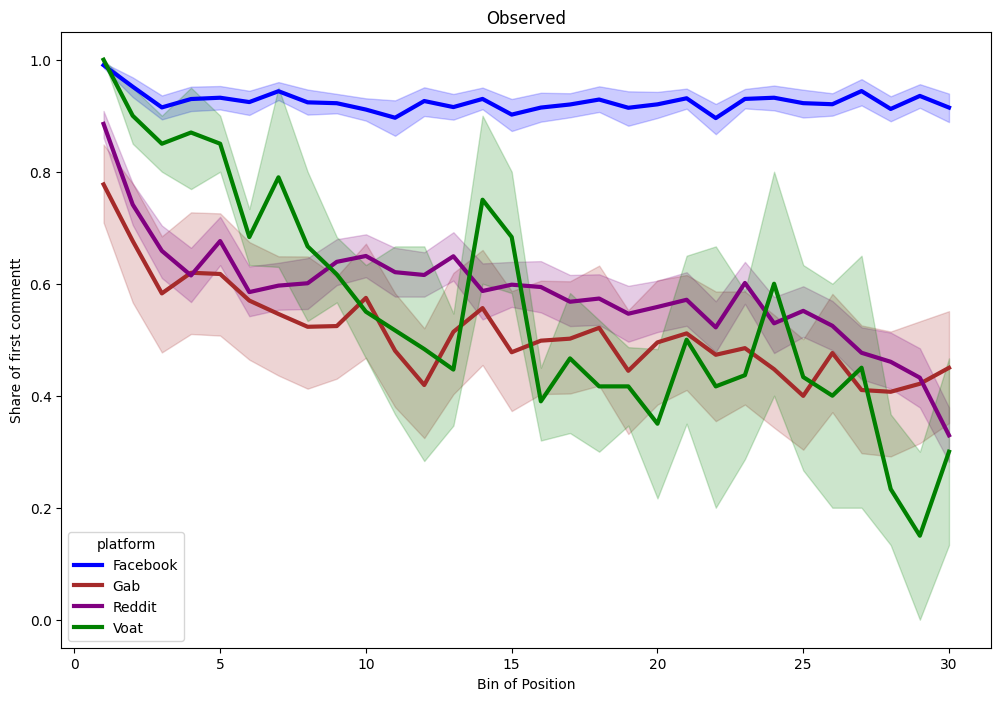

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo['platform'] = 'Reddit'
voo['platform'] = 'Voat'
fbo['platform'] = 'Facebook'
gbo['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo,  voo,fbo,gbo]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100]
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()
# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue','Gab': 'brown'}#,'YouTube':'red'}  # Custom palette with specified colors
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-82-701e9e9bbbdc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
<ipython-input-82-701e9e9bbbdc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')
<ipython-input-82-701e9e9bbbdc>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

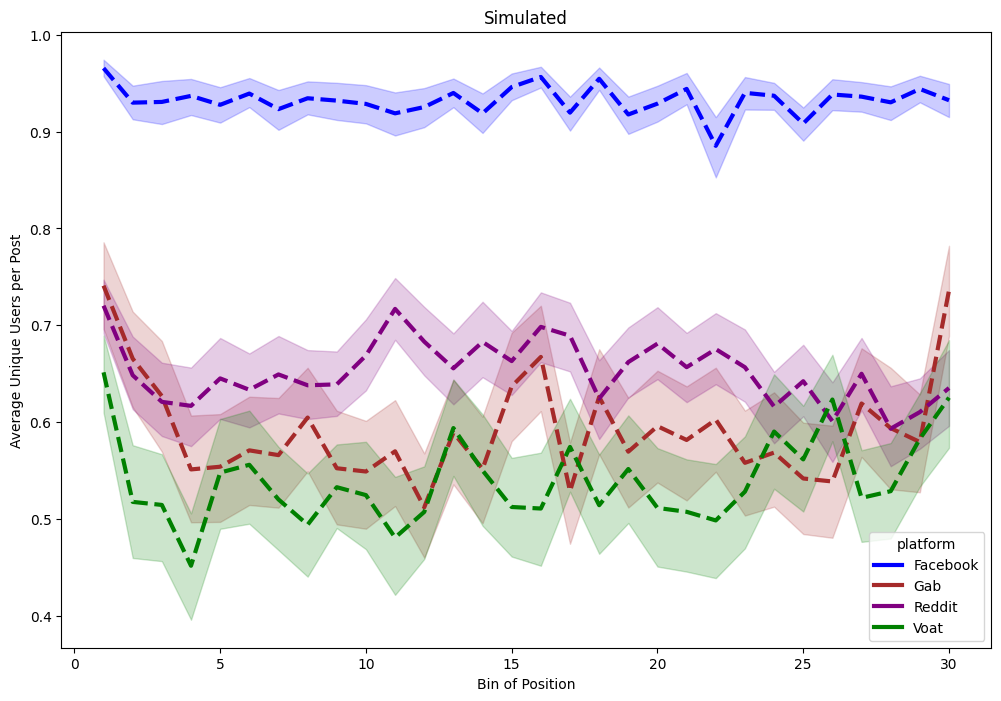

In [82]:

# Add 'platform' column to each DataFrame
rds['platform'] = 'Reddit'
vos['platform'] = 'Voat'
fbs['platform'] = 'Facebook'
gbs['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds,  vos,fbs,gbs]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df=df[df['number_of_comments']>100]
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Adjust bins to be between 1 and num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()

In [83]:

# Loss M1
df_line1 = agg_activity_sim
df_line2 =agg_activity_obs

# Assicurarsi che i due dataframe abbiano lo stesso indice per poter fare il confronto
df_line1 = df_line1.set_index(['bin_of_position', 'platform'])
df_line2 = df_line2.set_index(['bin_of_position', 'platform'])

# Unire i due dataframe sulle colonne 'Time Grid Value' e 'Platform'
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')

# Calcolare l'errore quadratico medio (MSE) per ogni piattaforma
mse_per_platform = df_merged.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

print(mse_per_platform)

platform
Facebook    0.030095
Gab         0.291761
Reddit      0.146639
Voat        0.205094
dtype: float64


## Number of comments for stymulus

In [18]:


def estimate_stimulus_reply(social):
    # Convert 'created_at' to datetime
    social['created_at'] = pd.to_datetime(social['created_at'])

    # Sort the data by 'post_id' and 'created_at'
    social = social.sort_values(by=['post_id', 'created_at'])

    # Assign a sequential index to each comment within each 'post_id' group
    social['indice_commento'] = social.groupby('post_id').cumcount()

    # Select columns of interest
    df = social[['indice_commento', 'user_id', 'post_id',
                 'sequential_number_of_comment_by_user_in_thread',
                 'number_of_comments_by_user_in_thread',
                 'number_of_comments']].copy()

    # Calculate the distance between comments
    df['distanza_tra_commenti'] = df.groupby(['user_id', 'post_id'])['indice_commento'].diff()
    df['distanza_tra_commenti_relativa'] = df['indice_commento'] / df['number_of_comments']

    # Filter for specific values
    df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread'] == 3) &
                     (df['number_of_comments_by_user_in_thread'] != df['sequential_number_of_comment_by_user_in_thread'])]

    # Extract the filtered data
    data_to_fit = df_filtered['distanza_tra_commenti_relativa']

    # Check for finite values
    data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

    # Fit the Beta distribution to the data
    a, b, loc, scale = beta.fit(data_to_fit)

    return a, b, loc, scale

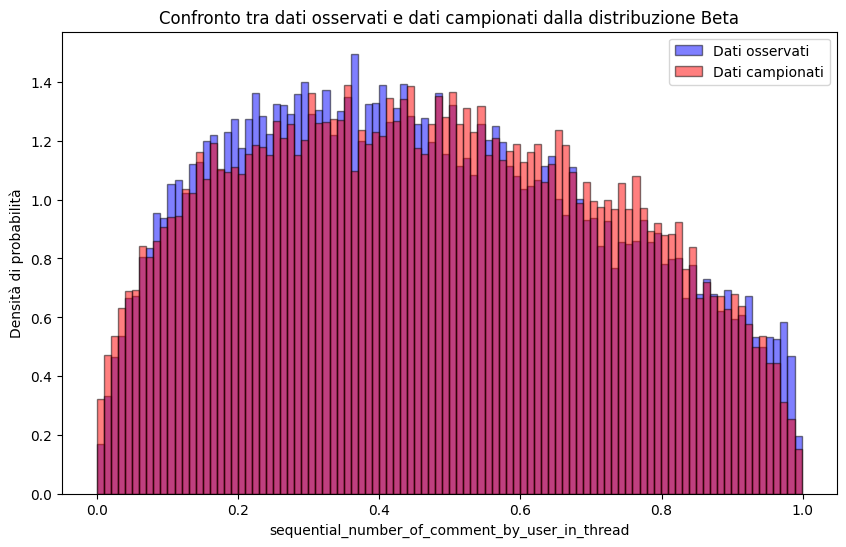

In [48]:
social=fb
#social['post_id']=social['root_submission']
#social['user_id']=social['user']
# Converti 'created_at' in formato datetime
social['created_at'] = pd.to_datetime(social['created_at'])

# Ordina i dati per 'post_id' e 'created_at'
social = social.sort_values(by=['post_id', 'created_at'])

# Assegna un indice sequenziale a ogni commento all'interno di ciascun gruppo di 'post_id'
social['indice_commento'] = social.groupby('post_id').cumcount()

# Seleziona le colonne di interesse
df = social[['indice_commento', 'user_id', 'post_id', 'sequential_number_of_comment_by_user_in_thread','number_of_comments_by_user_in_thread', 'number_of_comments']].copy()

df['distanza_tra_commenti'] = df.groupby(['user_id','post_id',])['indice_commento'].diff()
df['distanza_tra_commenti_relativa'] =df['indice_commento']/df['number_of_comments']
# Filtro per il valore 2

df_filtered = df[(df['sequential_number_of_comment_by_user_in_thread']==3) & ( df['number_of_comments_by_user_in_thread'] !=df['sequential_number_of_comment_by_user_in_thread'] )]


# Esempio di DataFrame filtrato (df_filtered) con i dati di 'distanza_tra_commenti'
# df_filtered = pd.DataFrame({'distanza_tra_commenti': ...})

# Estrazione dei dati filtrati
data_to_fit = df_filtered['distanza_tra_commenti_relativa']

# Verifica di valori finiti
data_to_fit = data_to_fit[np.isfinite(data_to_fit)]

# Fit della distribuzione Beta ai dati
a, b, loc, scale = beta.fit(data_to_fit)

# Campionamento dalla distribuzione Beta con i parametri ottenuti
sampled_data = beta.rvs(a, b, loc, scale, size=len(data_to_fit))

# Creazione dei bins comuni
num_bins = 100
bins = np.histogram_bin_edges(data_to_fit, bins=num_bins)

# Plot dei dati osservati e dei dati campionati
plt.figure(figsize=(10, 6))

# Istogramma dei dati osservati
plt.hist(data_to_fit, bins=bins, density=True, alpha=0.5, color='blue', edgecolor='black', label='Dati osservati')

# Istogramma dei dati campionati
plt.hist(sampled_data, bins=bins, density=True, alpha=0.5, color='red', edgecolor='black', label='Dati campionati')

plt.title('Confronto tra dati osservati e dati campionati dalla distribuzione Beta')
plt.xlabel('sequential_number_of_comment_by_user_in_thread')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()
